**Задание**

* Скачать датасет с фразами Симпсонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data
* Обучить word2vec на фразах персонажей
* Визуализировать embeddings по самым частотным словам (top 1000)
* Найти самые близкие слова для: 
homer - marge + bart bart - lisa + school marge - homer + home


In [ ]:
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from gensim.models import Word2Vec

import warnings
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [ ]:
!wget https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data/raw/master/simpsons_script_lines.csv.zip

--2023-02-14 20:44:35--  https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data/raw/master/simpsons_script_lines.csv.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sujanjoejacob/Text-mining-with-Simpsons-Data/master/simpsons_script_lines.csv.zip [following]
--2023-02-14 20:44:36--  https://raw.githubusercontent.com/sujanjoejacob/Text-mining-with-Simpsons-Data/master/simpsons_script_lines.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9163442 (8.7M) [application/zip]
Saving to: ‘simpsons_script_lines.csv.zip.1’

simpsons_script_lin 100%[===================>]   8.74M  37.4MB

In [ ]:
!unzip simpsons_script_lines.csv.zip

Archive:  simpsons_script_lines.csv.zip
replace simpsons_script_lines.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
df = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 8084: expected 13 fields, saw 20\nSkipping line 52607: expected 13 fields, saw 21\nSkipping line 59910: expected 13 fields, saw 21\n'
b'Skipping line 71801: expected 13 fields, saw 20\nSkipping line 73539: expected 13 fields, saw 21\nSkipping line 77230: expected 13 fields, saw 21\nSkipping line 78953: expected 13 fields, saw 21\nSkipping line 81138: expected 13 fields, saw 20\nSkipping line 86746: expected 13 fields, saw 22\nSkipping line 101154: expected 13 fields, saw 21\nSkipping line 115438: expected 13 fields, saw 20\nSkipping line 117573: expected 13 fields, saw 22\nSkipping line 130610: expected 13 fields, saw 22\n'
b'Skipping line 152970: expected 13 fields, saw 22\nSkipping line 153017: expected 13 fields, saw 20\nSkipping line

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158248 entries, 0 to 158247
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  158248 non-null  int64  
 1   episode_id          158248 non-null  int64  
 2   number              158248 non-null  int64  
 3   raw_text            158248 non-null  object 
 4   timestamp_in_ms     158248 non-null  object 
 5   speaking_line       158248 non-null  object 
 6   character_id        140727 non-null  object 
 7   location_id         157841 non-null  float64
 8   raw_character_text  140726 non-null  object 
 9   raw_location_text   157840 non-null  object 
 10  spoken_words        132089 non-null  object 
 11  normalized_text     132064 non-null  object 
 12  word_count          132089 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 15.7+ MB


In [ ]:
df.dropna(inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131685 entries, 0 to 158247
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  131685 non-null  int64  
 1   episode_id          131685 non-null  int64  
 2   number              131685 non-null  int64  
 3   raw_text            131685 non-null  object 
 4   timestamp_in_ms     131685 non-null  object 
 5   speaking_line       131685 non-null  object 
 6   character_id        131685 non-null  object 
 7   location_id         131685 non-null  float64
 8   raw_character_text  131685 non-null  object 
 9   raw_location_text   131685 non-null  object 
 10  spoken_words        131685 non-null  object 
 11  normalized_text     131685 non-null  object 
 12  word_count          131685 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 14.1+ MB


,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464.0,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9.0,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40.0,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0


In [ ]:
phrases = df['normalized_text'].apply(lambda x : x.split())
phrases[:10]

0     [no, actually, it, was, a, little, of, both, s...
1                               [wheres, mr, bergstrom]
2     [i, dont, know, although, id, sure, like, to, ...
3                       [that, life, is, worth, living]
4     [the, polls, will, be, open, from, now, until,...
5     [i, dont, think, theres, anything, left, to, say]
6                                                [bart]
7                   [victory, party, under, the, slide]
9                        [mr, bergstrom, mr, bergstrom]
10    [hey, hey, he, moved, out, this, morning, he, ...
Name: normalized_text, dtype: object

In [ ]:
model = Word2Vec(phrases, min_count=1)
print(model)
words = list(model.wv.vocab)
print(f'количество уникальных слов:  {len(words)}')


Word2Vec(vocab=46773, size=100, alpha=0.025)
количество уникальных слов:  46773


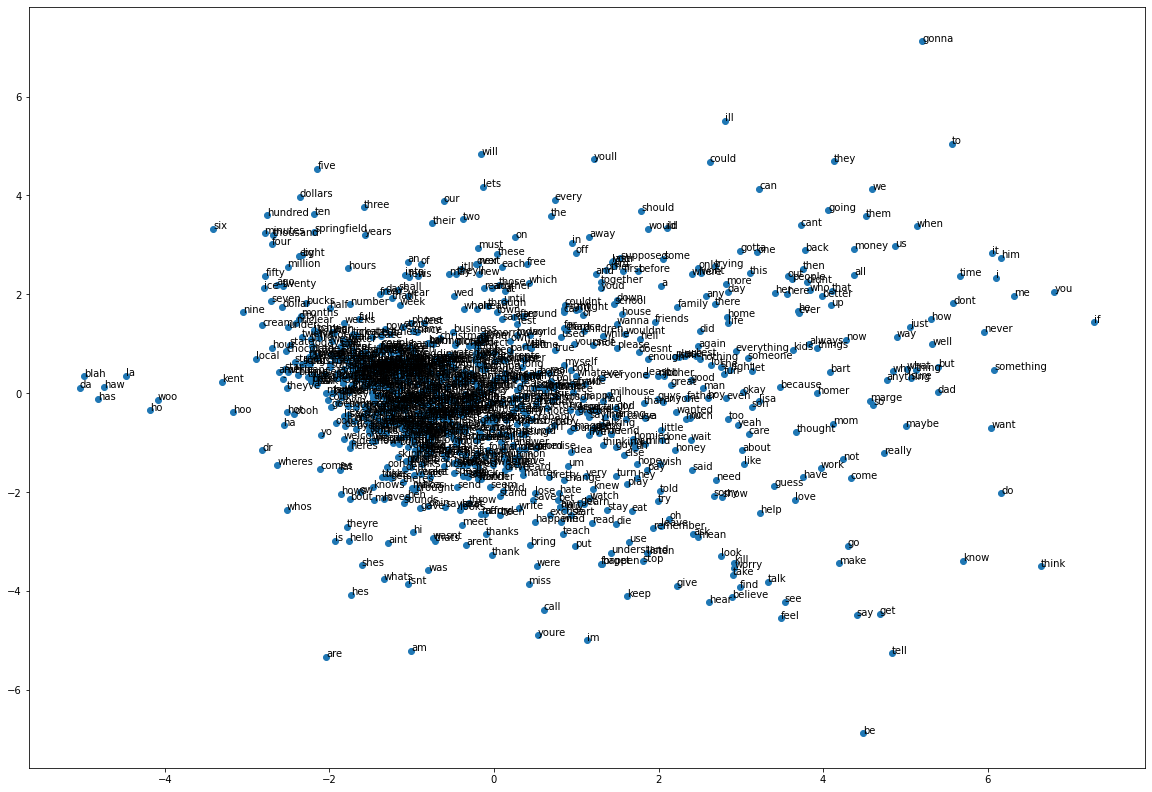

In [ ]:
n = 1000
top_n = model.wv.index2entity[:n]

X = model[top_n]

pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.figure(figsize=(20, 14))
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(top_n):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))    
plt.show()

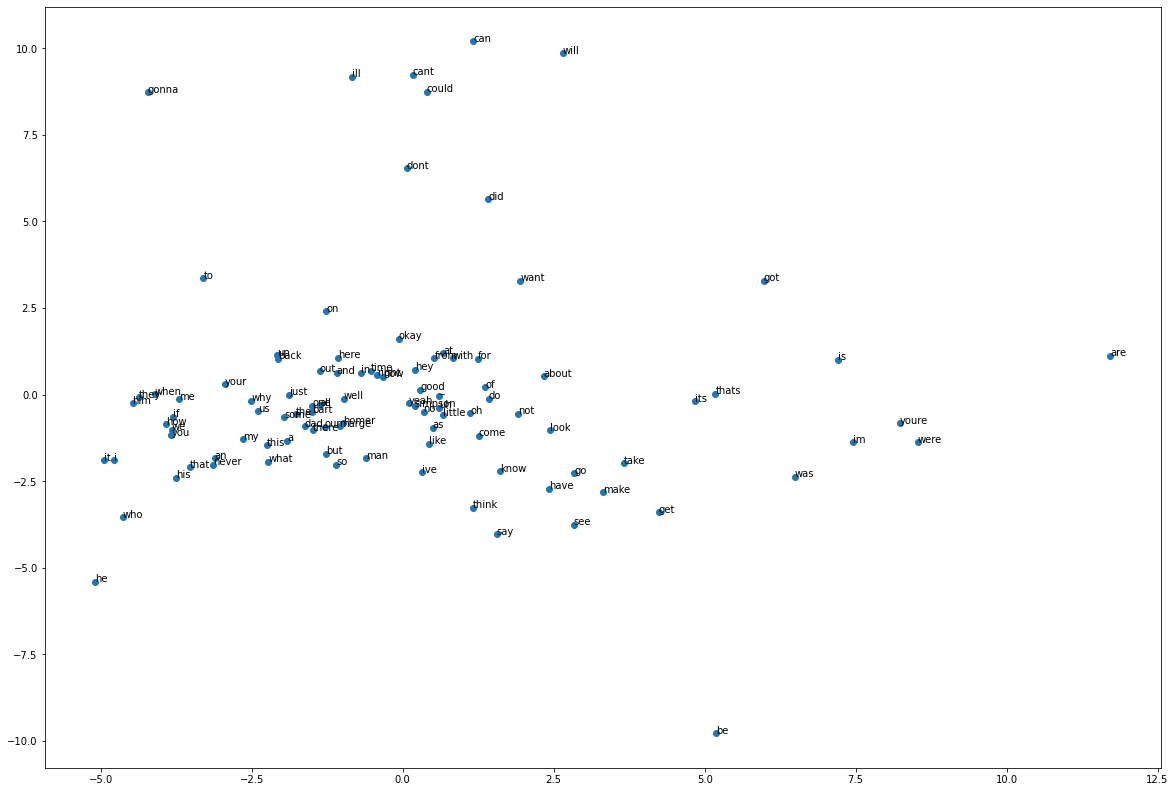

In [ ]:
n = 100
top_n = model.wv.index2entity[:n]

X = model[top_n]

pca = PCA(n_components=2)
result = pca.fit_transform(X)
plt.figure(figsize=(20, 14))
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(top_n):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))    
plt.show()

In [ ]:
topn = 10

print('Cамые близкие слова для:  homer - marge + bart') 
model.most_similar(positive=['homer', 'bart'], negative=['marge'], topn=topn)

Cамые близкие слова для:  homer - marge + bart


[('lisa', 0.8465710878372192),
 ('grampa', 0.7221797704696655),
 ('milhouse', 0.6747337579727173),
 ('pjs', 0.6714635491371155),
 ('maggie', 0.658275842666626),
 ('abe', 0.6579306125640869),
 ('boombaye', 0.6549538373947144),
 ('vendetti', 0.6540428400039673),
 ('dad', 0.6490414142608643),
 ('eliza', 0.644675612449646)]

In [ ]:
print('Cамые близкие слова для:  bart - lisa + school') 
model.most_similar(positive=['bart', 'school'], negative=['lisa'], topn=topn)

Cамые близкие слова для:  bart - lisa + school


[('church', 0.7821021676063538),
 ('store', 0.7560770511627197),
 ('orphanage', 0.7479429244995117),
 ('house', 0.7461708784103394),
 ('game', 0.7434123754501343),
 ('dinner', 0.7374016046524048),
 ('bed', 0.7264000177383423),
 ('bar', 0.722050666809082),
 ('home', 0.7174171209335327),
 ('once', 0.7168991565704346)]

In [ ]:
print('Cамые близкие слова для:  marge - homer + home') 
model.most_similar(positive=['marge', 'home'], negative=['homer'], topn=topn)

Cамые близкие слова для:  marge - homer + home


[('back', 0.7996140718460083),
 ('sleep', 0.7361173629760742),
 ('bed', 0.7318856716156006),
 ('dinner', 0.6778459548950195),
 ('here', 0.675676167011261),
 ('while', 0.6652531623840332),
 ('school', 0.6577903032302856),
 ('boys', 0.648931622505188),
 ('away', 0.6474334001541138),
 ('tomorrow', 0.646328330039978)]